# <span id="chap_concepts_networks"></span> Networks

A **network** consists of a collection of **nodes** (also known as **vertices**), which are connected to each other by a collection of **edges**. Each edge connects two nodes.

Typically a network is actually a representation of something else, where the network extracts and simplifies the description of a cmore complex real "thing". Examples of networks include:

* A road network. Nodes represent junctions, while edges represent streets that connect junctions (nodes) together.
* A social network. Here nodes represent people, with edges representing relationships between them such as friendship, parentage, and so forth.
* A protein interaction network. These are used to model the biology of cells. A node represents a protein, and an edge represents the fact that two proteins interact in some way within the cell.

A few things are immediately apparent from these examples. Firstly, networks are a very general idea that can apply to an awful lot of phenomena. Secondly, the simple description we used may be inadequate for some systems, anmd we may need to introduce more structure. For example we might want the edges in a social network to be **labelled** with what kind of relationship they represent: friends, colleagues, family, and so on. (But it's interesting to note here that [Facebook](http://www.facebook.com) doesn't do this, and treats everyone as a "friend": it only has one kind of edge. Sometimes simplicity can work best.) We might also want to label nodes, for example with a name or other identifier. We might want edges to be **directed**, for example to indicate that someone is the parent of someone else and not *vice versa*.

Thirdly, networks come in all sorts of sizes. Biological networks are often overwhelmingly large because of the myriad elements and interactions that make up biological systems. We usually refer to the size of a network as its **order**, being simply the number of nodes it contains. 

Finally, we might observe that networks might have very different patterns of connectivity. Two nodes that are connected by an edge are said to be **adjacent**. A node might be adjacent to a lot of other nodes (that is, have a lot of edges that connect it to other ndoes), while others may be adjacent to very few. In the social network case these differences might correspond to people with lots of friends *versus* people who are more solitary (or isolated). Things might get even more complicated, if we consider that people who are very popular often have proportionately more friends who are themselves very popular. All these features are issues of the **topology** of a network, and topology turns out to be one of the most interesting and powerful features of complex networks.  

### <span id="sec_concepts_networks_graphs"></span> Networks or graphs?

The structures we're referring to as networks were historically called **graphs**. This is initially confusing for people who think of graphs as a plot of the relationships among two (or more) variables. It's especially confusing in this context, as we'll frequently be drawing this second kind of graph when exploring the properties of networks &ndash; the *other* kind of graph.

For this reason we'll try to use the term "network" for the node-and-edge structure, and keep "graph" for the line-and-error-bar structure. It's important to bear in mind, though, that terms like "network" and "graph" as well as "network science" and "graph theory", can be used somewhat interchangeably.

## <span id="sec_concepts_networks_building"></span> Building networks in `networkx`

Since we're concerned with using Python to build networks, we can start by introducing the core Python package `networkx`. `networkx` provides a collection of classes and algorithms for performing network science. It's a very complicated piece of software with a lot of fascinating and useful features that we'll introduce and explore as we go along. For the moment, though, we'll start with the really basic functionality.

As well as `networkx`, we need some other packages. `numpy` is the Python standard mathematical library that provides a host of functions and capabilities that find application everfywhere in network science. To help visualise the networks we build we use `matplotlib`, which is the standard Python package for drawing scientific diagrams. Again, it's a frighteningly useful piece of kit that we'll gradually exercise more and more. We'll also make use of `seaborn`, which modifies `matplotlib` with better colour schemes and the like. Bringing all these into the notebook and making them work in-line involves the following Python code: 

In [2]:
import networkx                                # network representation and manipulation
import numpy                                   # standard mathematical and statistical functions

import matplotlib as mpl                       # standard scientific drawing package
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt                # matplotlib extensions
import matplotlib.cm as cmap                   # ...and colourmaps
import seaborn                                 # ...and better colour schemes and other goodies

/Users/sd/research/writing/complex-networks-complex-processes/notebook/cncp/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


`networkx` represents networks using a class called `Graph` &ndash; slightly annoying given the discussion [above](#sec_concepts_networks_graphs), but that's the way things turn out. To build a network, we simply build an instance of this class:

In [3]:
g = networkx.Graph()

This results in an empty network with no nodes or edges. We can add nodes individually using the `add_node()` method, giving each node a label if we want to:

In [4]:
g.add_node(1)
g.add_node(2)

This results in a network with two nodes, so of order 2 &ndash; which we can check:

In [5]:
print g.order()

2


The network still doesn't have an edges, so let's add one:

In [6]:
g.add_edge(1, 2)

This shows why we need to label the nodes: so we have a way of identifying them when adding edges.

What does this network look like? We'll let `networkx` show us:

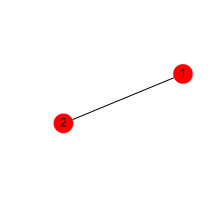

In [7]:
# create a figure with no axes
fig = plt.figure(figsize = (3, 3))   # an in-line figure
plt.gca().set_axis_off()             # turn off the axes, since they mean nothing for networks

# use MetworkX to draw the network
networkx.draw_networkx(g, node_size = 400)

_ = plt.show()

This was a three-stage process. First we create a figure in the notebook and turn its axes off, since these make no sense when drawing networks. (They make perfect sense when drawing other scientific figures, of course.) We then use the `draw_networkx()` function to draw the network, providing an optioanl parameter that makes the node markers larger. Finally we "show" the figure.

Like a lot of `networkx` functions, `draw_networkx()` is extremely flexible and provides a lot of optional parameters to control exactly how it operates: we'll see more examples below. Internally, it uses `matplotlib` to actually do the drawing.

Let's add some more nodes and edges. Rather than add them one by one, we can add a set of nodes from a collection such as a list or array; similarly, for edges, we can provide list of pairs of node names:

In [8]:
g.add_nodes_from([3, 4])
g.add_edges_from([(2, 3), (2, 4)])

If we re-draw the network using the same approach as before, we can see the new nodes and edges:

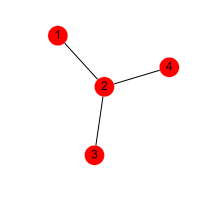

In [9]:
fig = plt.figure(figsize = (3, 3))
plt.gca().set_axis_off()
networkx.draw_networkx(g, node_size = 400)

_ = plt.show()

Having built a network, we might want to query it. We can do this in several ways, and as an example let's get the **neighbourhood** of node 2, the collection of nodes it's adjacent to:

In [16]:
print "Neighbours of node {n}: {ns}".format(n = 2,
                                            ns = g.neighbors(2))

Neighbours of node 2: [1, 3, 4]


We might also want to enumerate all the nodes, and all the edges:

In [11]:
print "Nodes: {ns}".format(ns = g.nodes())
print "Edges: {es}".format(es = g.edges())

Nodes: [1, 2, 3, 4]
Edges: [(1, 2), (2, 3), (2, 4)]


Or maybe just the edges **incident** on node 1:

In [12]:
print "Edges adjacent to node {n}: {es}".format(n = 1,
                                                es = g.edges(1))

Edges adjacent to node 1: [(1, 2)]


This is enough to show the style of `networkx` coding. We can now move away from such toy examples and onto networks of more interest. 

## <span id="sec_concepts_networks_lattice"></span> Lattices

Perhaps the simplest kind of network that actually might be of interest is a regular two-dimensional lattice or mesh. Think of a chess board, consisting of an eight-by-eight grid of squares. If we conside the intersections of the corners of the squares, with each other and with the edge of the board, forming the vertices of a 9x9 lattice. (An even better example is a [go board](https://en.wikipedia.org/wiki/Go_%28game%29), which is a 19x19 lattice of points on which one can play stones.)

We can use `networkx` to define a lattice, building on the approach we used [above](#sec_concepts_networks_building). This consists of two parts: creating a network with the right number of nodes, and then linking them together with the right number of edges. The latter part is usually more subtle than the former. Let's first prtesent the `networkx` code to build a two-dimensional lattice, and then dig into exactly what we've done:

In [13]:
def lattice_graph( lattice_rows, lattice_columns ):
    """Create a regular 2D lattice with the given dimensions.
    
    :param lattice_rows: the number of rows in the lattice
    :param lattice_cols: the nmumber of columns in the lattice
    :returns: the lattice"""
    
    # create the network and populate it with nodes indexed by a single integer
    lattice = networkx.Graph()
    lattice.add_nodes_from(xrange(lattice_rows * lattice_columns))
    
    # add edges to the main body of the lattice
    for r in xrange(0, lattice_rows - 1):             # sweep top-left to bottom-right
        for c in xrange(0,lattice_columns - 1):
            i = r * lattice_columns + c
            lattice.add_edge(i, i + 1)                # edge to right neighbour
            lattice.add_edge(i, i + lattice_columns)  # edge to south neighbour (row below)
        
    # add edges along the right-hand column
    for r in xrange(0, lattice_rows - 1):
        i = (r + 1) * lattice_columns - 1    
        lattice.add_edge(i, i + lattice_columns)      # edge to south neighbour (row below)
        
    # add edges along the bottom (south) edge
    for c in xrange(0, lattice_columns - 1):
        i = (lattice_rows - 1) * lattice_columns + c        
        lattice.add_edge(i, i + 1)                    # edge to right neighbour
        
    return lattice

The first thing to note is that we've named the function `lattice_graph()`, which immediately contradicts what we said [above](#sec_concepts_networks_graphs) about referring to these structures as "networks". But `networkx` itself includes lots of functions for generating networks that follow this naming convention, so it seems sensible to be consistent with that even at the risk of confusion. 

To build the lattice, we first create an empty network and populate it with nodes. We number the nodes in a predictable fashion so we can refer to them later. We then add edges. For all except the last column and row, we add an edge to the east and south neighbours of each node: a moment's though should convince you that this fleshes out most of the lattice. We then add edges to complete the lattice in the final right-hand column and bottom row, which costs respectively of only north-south and only east-west edges.

If we compare this to the toy example from [above](#sec_concepts_networks_building), the only difference is that for the lattice we *calculated* the endpoints of each edge according to their indices, since there's a straightforward relationship between index and edge. This of course has the advantage that it works for lattices of arbitrary size, but is a technique that only works this weay for **regular** networks where there's some definite deterministic pattern to be captured. [Later](er-networks.ipynb) we'll see similar techniques applied to stochastic patterns, where the exact edges that are connected are selected randomly but nevertheless in a structured fashion that we can code in an algorithm. 

Constructing the lattice is perhaps a slightly more involved process than you might have expected, but we have to be careful that we add all the edges we want *and only those edges*. Spefifically, although all the non-edge nodes have links going in four directions, there's only one edge between each pair of nodes, and we have to be careful not to add too many. Notice how `networkx` manipulates the network. We give nodes unique indices (integers in this case) and then use these to identify the nodes at the ends of each edge we add.

We can now use our function to create a network with whatever dimensions we desire:

In [14]:
mesh = lattice_graph(10, 10)

We can perform all the operastions we saw above, for example to query the neighbourhood of a node to see what its neighbours are:

In [18]:
print "Neighbours of node {n}: {ns}".format(n = 2,
                                            ns = mesh.neighbors(2))

Neighbours of node 2: [1, 3, 12]


Does this make sense? Node 2 is the second column of the first row, so it has 1 and 3 as left and right neighbours. The lattice has 10 columns, so the same column of the next row is 2 + 10 = 12. This is an important sanity check, which only works because we know (from having access to the source code of the function) that it uses this particular numbering scheme.